In [1]:
# Cellule 1 – Imports & chargement

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Chargement du CSV (adapter le chemin si besoin)
path = r"C:\Users\admin\Desktop\insurance_claims.csv"

try:
    df = pd.read_csv(path)
    print(f"✅ Fichier chargé avec succès. Taille initiale: {df.shape}")
except FileNotFoundError:
    print(f"❌ ERREUR CRITIQUE : Le fichier est introuvable à l'adresse : {path}")
    print("Vérifiez que le nom du fichier est correct et qu'il est bien sur le Bureau.")
    raise # Arrête l'exécution si le fichier n'est pas trouvé


print("Dimensions initiales :", df.shape)
df.head()


✅ Fichier chargé avec succès. Taille initiale: (1000, 40)
Dimensions initiales : (1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [2]:
# Cellule 2 – Nettoyage de base

# Suppression colonne poubelle si présente
if '_c39' in df.columns:
    df.drop('_c39', axis=1, inplace=True)

# Remplir les NaN par "Unknown" pour certains champs
cols_to_fix = ['collision_type', 'property_damage',
               'police_report_available', 'authorities_contacted']

for col in cols_to_fix:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

# Colonnes à enlever (identifiants ou très peu informatives)
cols_to_remove = [
    'policy_number',
    'incident_location',
    'total_claim_amount',
    'insured_zip',
    'auto_year'
]

for col in cols_to_remove:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

print("Dimensions après nettoyage de base :", df.shape)
df.head()


Dimensions après nettoyage de base : (1000, 34)


,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,...,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,fraud_reported
0,328,48,2014-10-17,OH,250/500,1000,1406.91,0,MALE,MD,...,YES,1,2,YES,6510,13020,52080,Saab,92x,Y
1,228,42,2006-06-27,IN,250/500,2000,1197.22,5000000,MALE,MD,...,?,0,0,?,780,780,3510,Mercedes,E400,Y
2,134,29,2000-09-06,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,...,NO,2,3,NO,7700,3850,23100,Dodge,RAM,N
3,256,41,1990-05-25,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,...,?,1,2,NO,6340,6340,50720,Chevrolet,Tahoe,Y
4,228,44,2014-06-06,IL,500/1000,1000,1583.91,6000000,MALE,Associate,...,NO,0,1,NO,1300,650,4550,Accura,RSX,N


In [3]:
# EDA 1 – Aperçu global & valeurs manquantes

print("Aperçu des 5 premières lignes :")
display(df.head())

print("\nTypes de variables :")
print(df.dtypes)

print("\nStatistiques descriptives (numériques) :")
display(df.describe())

print("\nNombre de valeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])


Aperçu des 5 premières lignes :


,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,...,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,fraud_reported
0,328,48,2014-10-17,OH,250/500,1000,1406.91,0,MALE,MD,...,YES,1,2,YES,6510,13020,52080,Saab,92x,Y
1,228,42,2006-06-27,IN,250/500,2000,1197.22,5000000,MALE,MD,...,?,0,0,?,780,780,3510,Mercedes,E400,Y
2,134,29,2000-09-06,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,...,NO,2,3,NO,7700,3850,23100,Dodge,RAM,N
3,256,41,1990-05-25,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,...,?,1,2,NO,6340,6340,50720,Chevrolet,Tahoe,Y
4,228,44,2014-06-06,IL,500/1000,1000,1583.91,6000000,MALE,Associate,...,NO,0,1,NO,1300,650,4550,Accura,RSX,N



Types de variables :
months_as_customer               int64
age                              int64
policy_bind_date                object
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage                 object
bod

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,property_claim,vehicle_claim
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,1136.000000,1256.406150,1.101000e+06,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,7433.420000,7399.570000,37928.950000
std,115.113174,9.140287,611.864673,244.167395,2.297407e+06,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,4880.951853,4824.726179,18886.252893
min,0.000000,19.000000,500.000000,433.330000,-1.000000e+06,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,70.000000
25%,115.750000,32.000000,500.000000,1089.607500,0.000000e+00,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,4295.000000,4445.000000,30292.500000
50%,199.500000,38.000000,1000.000000,1257.200000,0.000000e+00,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,6775.000000,6750.000000,42100.000000
75%,276.250000,44.000000,2000.000000,1415.695000,0.000000e+00,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,11305.000000,10885.000000,50822.500000
max,479.000000,64.000000,2000.000000,2047.590000,1.000000e+07,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,21450.000000,23670.000000,79560.000000



Nombre de valeurs manquantes par colonne :


Series([], dtype: int64)

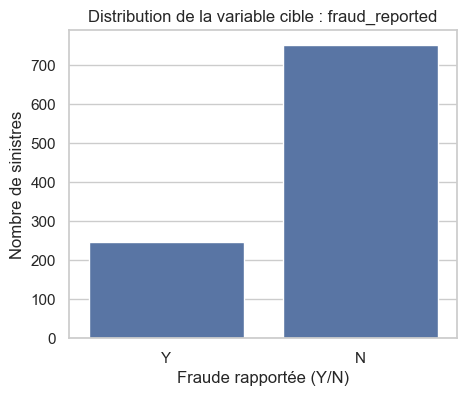

fraud_reported
N    753
Y    247
Name: count, dtype: int64

Répartition en pourcentage :
fraud_reported
N    0.753
Y    0.247
Name: proportion, dtype: float64


In [4]:
# EDA 2 – Distribution de la variable cible fraud_reported

if 'fraud_reported' in df.columns:
    plt.figure(figsize=(5, 4))
    sns.countplot(x='fraud_reported', data=df)
    plt.title("Distribution de la variable cible : fraud_reported")
    plt.xlabel("Fraude rapportée (Y/N)")
    plt.ylabel("Nombre de sinistres")
    plt.show()

    print(df['fraud_reported'].value_counts())
    print("\nRépartition en pourcentage :")
    print(df['fraud_reported'].value_counts(normalize=True).round(3))
else:
    print("La colonne 'fraud_reported' n'est pas présente dans le dataframe.")


Colonnes numériques : ['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'injury_claim', 'property_claim', 'vehicle_claim']


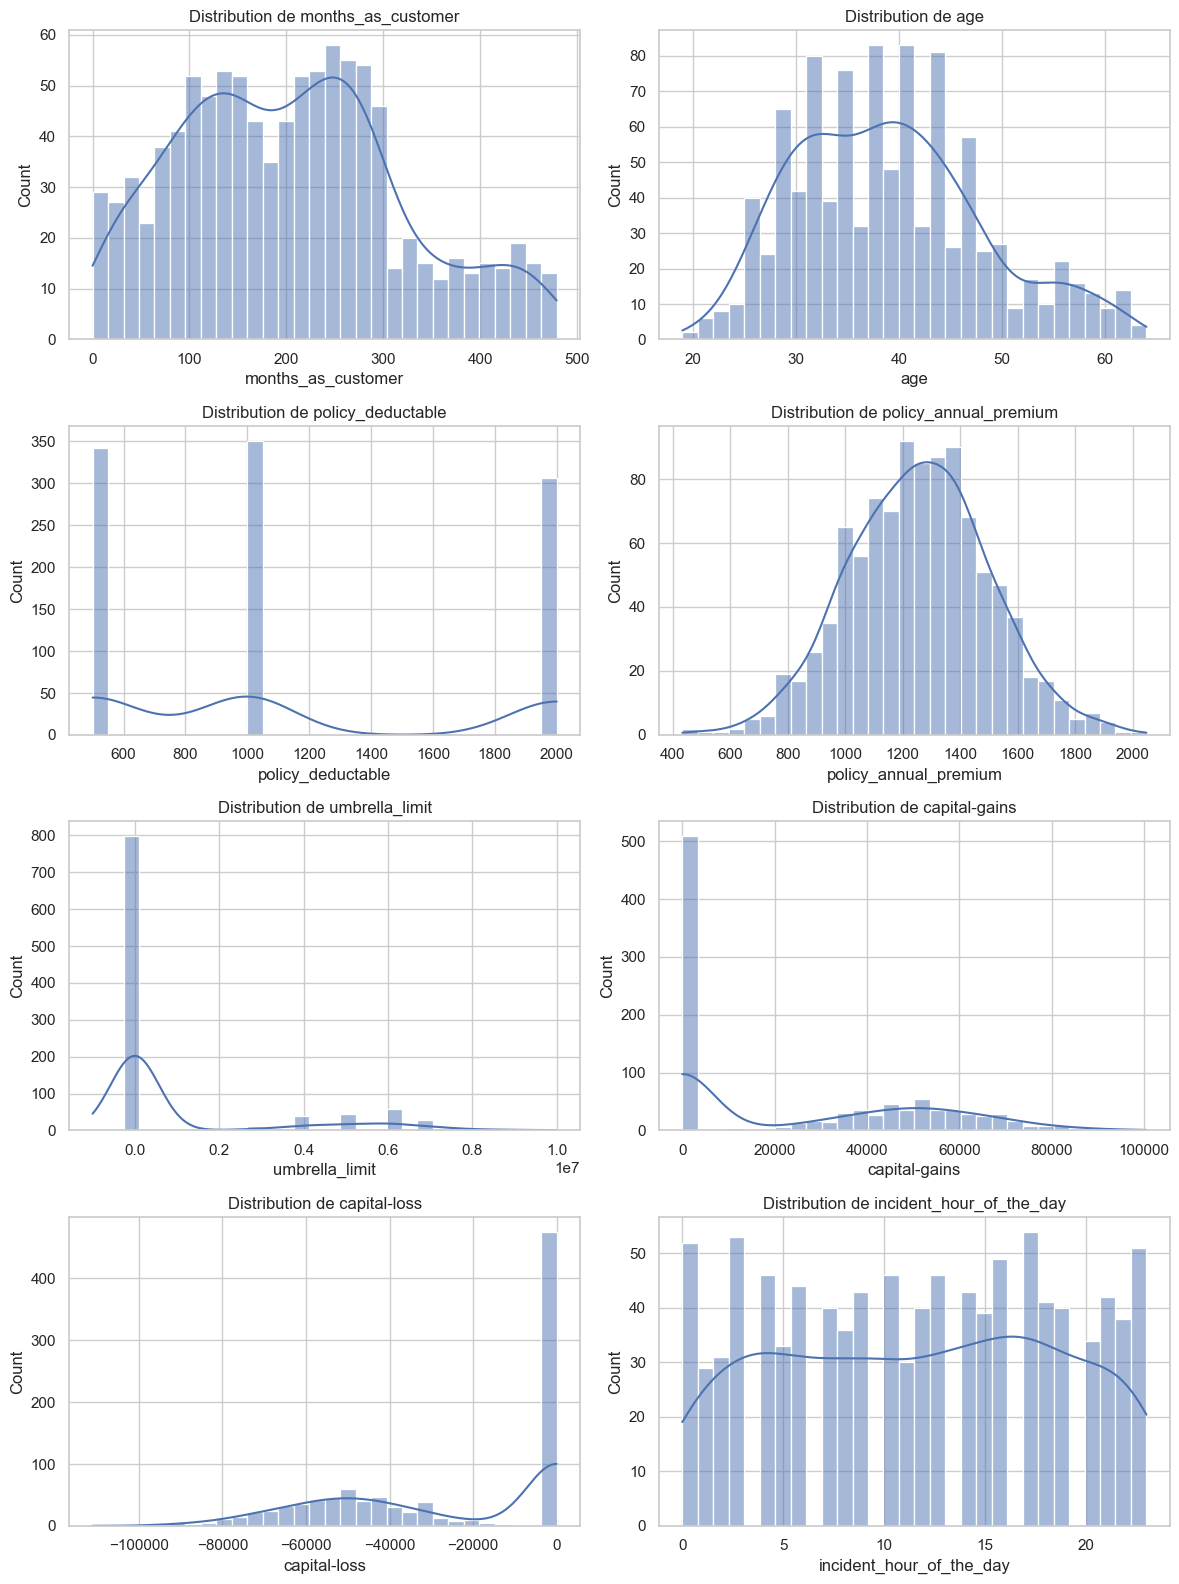

In [5]:
# EDA 3 – Distributions des principales variables numériques

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Colonnes numériques :", numeric_cols)

# On peut exclure la cible si elle est déjà numérique (au cas où)
if 'fraud_reported' in numeric_cols:
    numeric_cols.remove('fraud_reported')

# On limite à max 8 variables pour ne pas surcharger
numeric_cols_to_plot = numeric_cols[:8]

n_cols = 2
n_rows = int(np.ceil(len(numeric_cols_to_plot) / n_cols))

plt.figure(figsize=(12, 4 * n_rows))

for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")

plt.tight_layout()
plt.show()


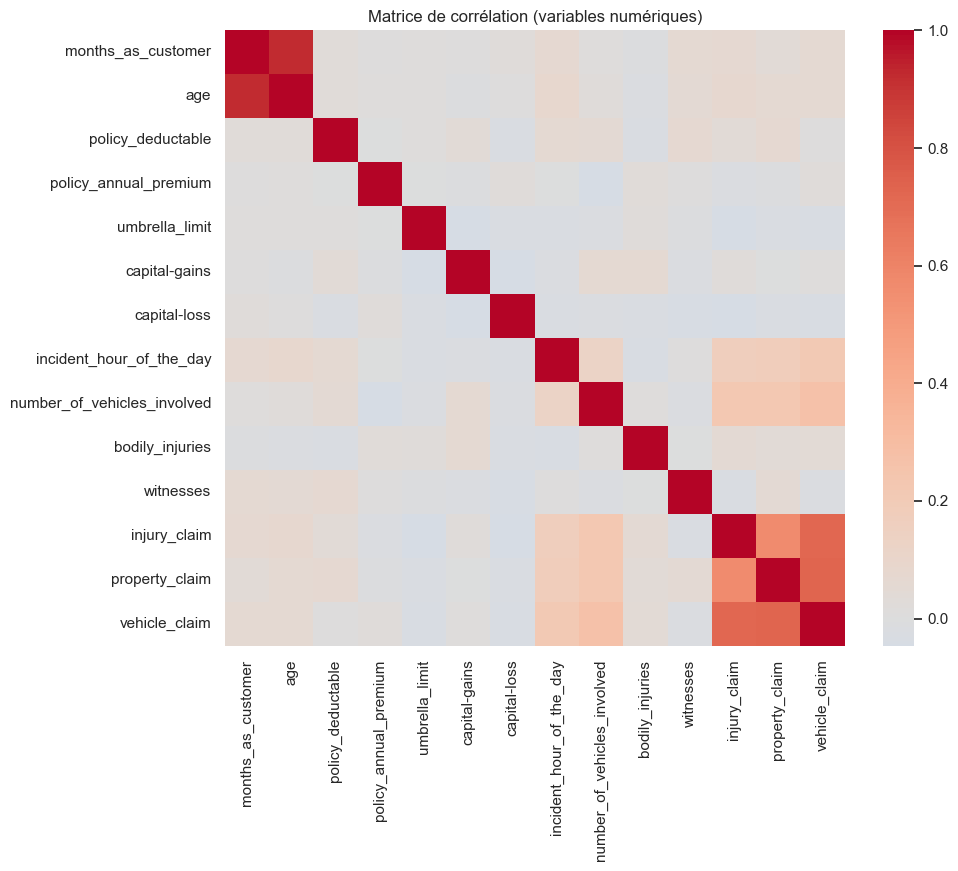

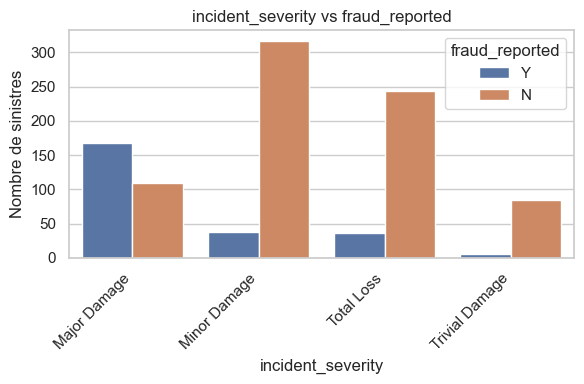

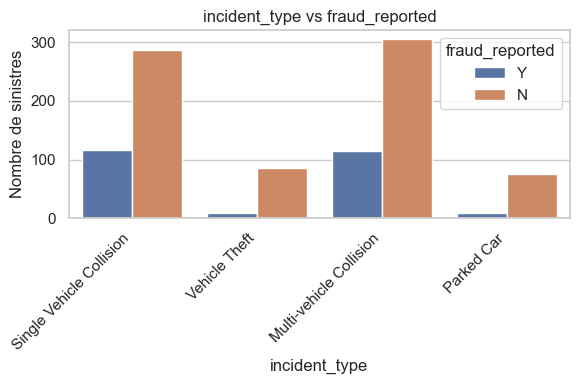

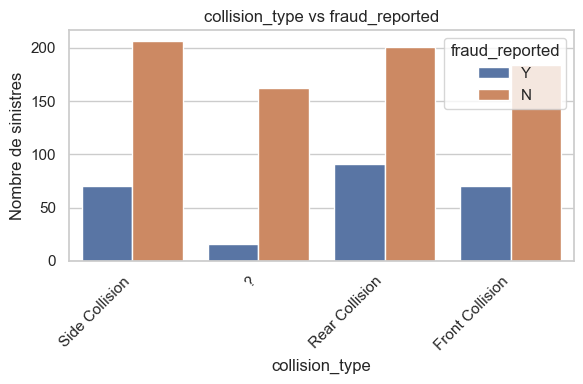

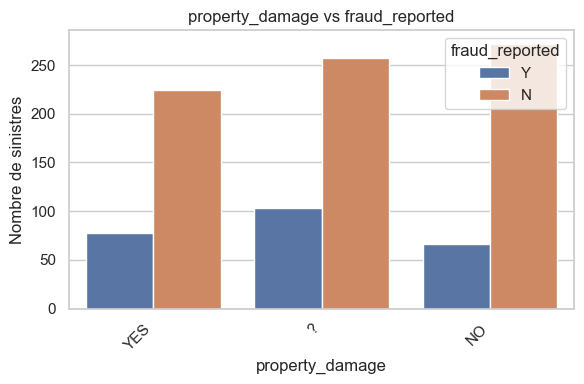

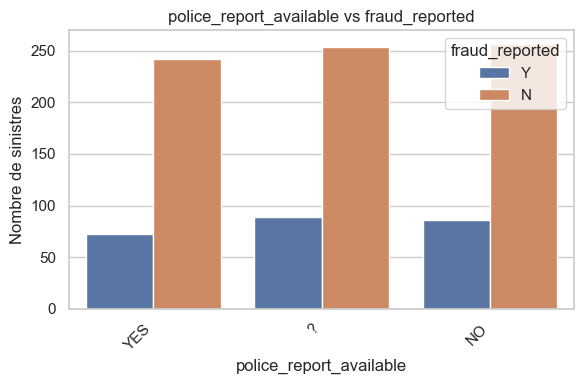

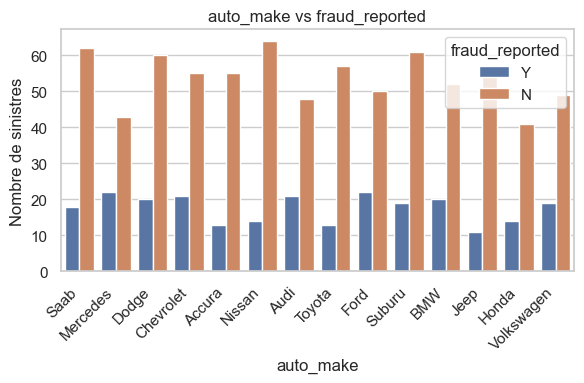

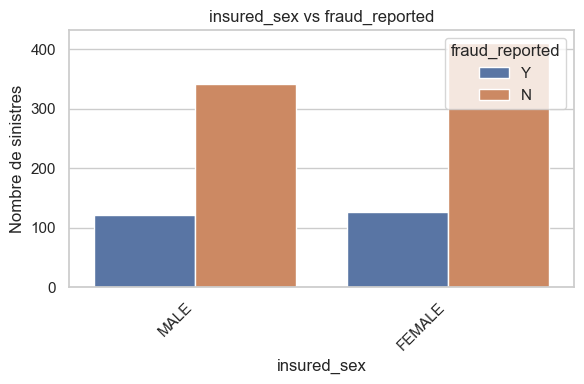

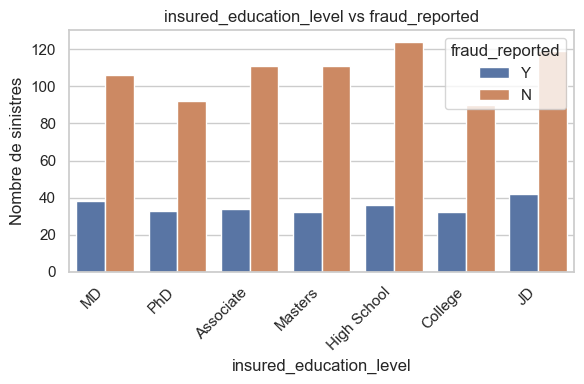

In [6]:
# EDA 4 – Matrice de corrélation & relations avec la cible

# --- Matrice de corrélation sur les numériques ---
if len(numeric_cols) > 1:
    corr = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Matrice de corrélation (variables numériques)")
    plt.show()
else:
    print("Pas assez de variables numériques pour une matrice de corrélation.")

# --- Relations avec la fraude pour quelques variables catégorielles ---
cat_cols_candidates = [
    'incident_severity',
    'incident_type',
    'collision_type',
    'property_damage',
    'police_report_available',
    'auto_make',
    'insured_sex',
    'insured_education_level'
]

cat_cols_to_plot = [c for c in cat_cols_candidates if c in df.columns]

for col in cat_cols_to_plot:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='fraud_reported', data=df)
    plt.title(f"{col} vs fraud_reported")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Nombre de sinistres")
    plt.legend(title="fraud_reported")
    plt.tight_layout()
    plt.show()


count    1.000000e+03
mean     1.101000e+06
std      2.297407e+06
min     -1.000000e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: umbrella_limit, dtype: float64


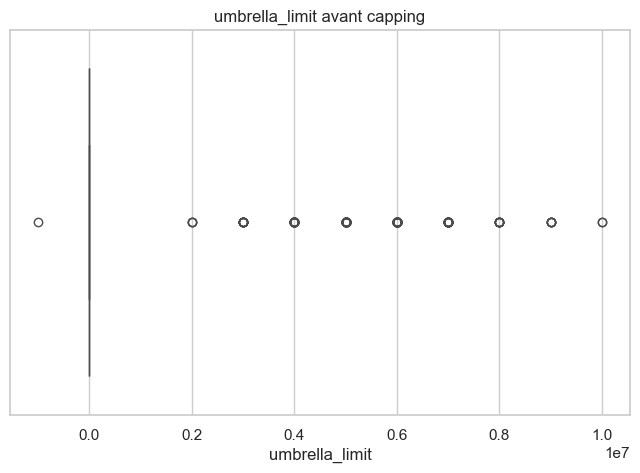

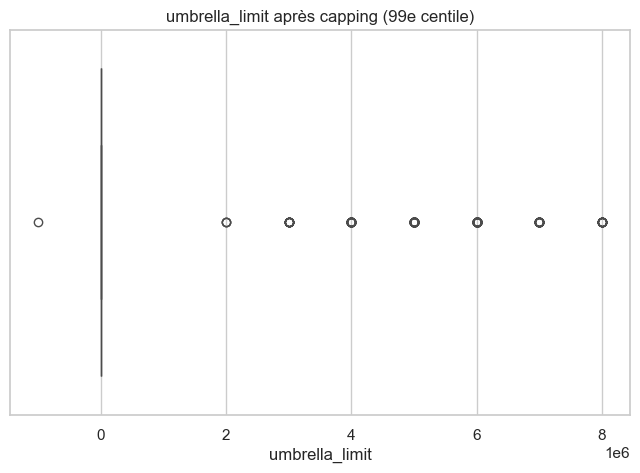

In [7]:
# Cellule 3 – Traitement des outliers sur umbrella_limit

if 'umbrella_limit' in df.columns:
    print(df['umbrella_limit'].describe())

    plt.figure()
    sns.boxplot(x=df['umbrella_limit'])
    plt.title("umbrella_limit avant capping")
    plt.show()

    upper_limit = df['umbrella_limit'].quantile(0.99)
    df.loc[df['umbrella_limit'] > upper_limit, 'umbrella_limit'] = upper_limit

    plt.figure()
    sns.boxplot(x=df['umbrella_limit'])
    plt.title("umbrella_limit après capping (99e centile)")
    plt.show()


In [8]:
# Cellule 4 – Préparation X / y, encodage, split, standardisation, SMOTE

# Encodage de la cible
df['fraud_reported'] = df['fraud_reported'].map({'N': 0, 'Y': 1})

# Séparation features / target
y = df['fraud_reported']
X = df.drop('fraud_reported', axis=1)

# Suppression colonnes de dates (si présentes)
date_cols = ['policy_bind_date', 'incident_date', 'date_of_birth']
for col in date_cols:
    if col in X.columns:
        X.drop(col, axis=1, inplace=True)

# Encodage one-hot des variables catégorielles
X = pd.get_dummies(X, drop_first=True)

print("Shape de X après encodage :", X.shape)

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train :", X_train.shape, "Test :", X_test.shape)
print("Répartition y_train :")
print(y_train.value_counts(normalize=True))

# Standardisation des colonnes numériques
num_cols = X_train.select_dtypes(include=['number']).columns

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

# SMOTE uniquement sur le train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Après SMOTE – X_train_res :", X_train_res.shape)
print("Répartition y_train_res :")
print(y_train_res.value_counts())


Shape de X après encodage : (1000, 142)
Train : (700, 142) Test : (300, 142)
Répartition y_train :
fraud_reported
0    0.752857
1    0.247143
Name: proportion, dtype: float64
Après SMOTE – X_train_res : (1054, 142)
Répartition y_train_res :
fraud_reported
0    527
1    527
Name: count, dtype: int64


In [9]:
# Cellule 5 – Définition des modèles & fonction d'évaluation

models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=42
    ),
    "SVM": SVC(
        kernel='rbf', class_weight='balanced', probability=True, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, class_weight='balanced', random_state=42
    )
}

# Voting classifier (soft)
voting_clf = VotingClassifier(
    estimators=[(name.replace(" ", "_"), m) for name, m in models.items()],
    voting='soft'
)
models["Voting Classifier"] = voting_clf


def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    """Fit un modèle et retourne un dictionnaire de métriques."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
        roc = roc_auc_score(y_te, y_proba)
    else:
        y_proba = None
        roc = np.nan

    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec  = recall_score(y_te, y_pred)
    f1   = f1_score(y_te, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy  : {acc:.3f}")
    print(f"Precision : {prec:.3f}")
    print(f"Recall    : {rec:.3f}")
    print(f"F1-score  : {f1:.3f}")
    print(f"ROC-AUC   : {roc:.3f}")
    print("\nClassification report :")
    print(classification_report(y_te, y_pred))

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc
    }


In [10]:
# Cellule 6 – Entraînement + tableau comparatif (Partie A)

results = []

for name, model in models.items():
    res = evaluate_model(name, model, X_train_res, y_train_res, X_test, y_test)
    results.append(res)

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print("\n\nRésumé des performances (trié par F1-score) :")
results_df



=== Logistic Regression ===
Accuracy  : 0.803
Precision : 0.632
Recall    : 0.486
F1-score  : 0.550
ROC-AUC   : 0.820

Classification report :
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       226
           1       0.63      0.49      0.55        74

    accuracy                           0.80       300
   macro avg       0.74      0.70      0.71       300
weighted avg       0.79      0.80      0.79       300


=== SVM ===
Accuracy  : 0.763
Precision : 0.571
Recall    : 0.162
F1-score  : 0.253
ROC-AUC   : 0.748

Classification report :
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       226
           1       0.57      0.16      0.25        74

    accuracy                           0.76       300
   macro avg       0.67      0.56      0.56       300
weighted avg       0.73      0.76      0.71       300


=== Random Forest ===
Accuracy  : 0.773
Precision : 0.579
Recall    : 0.2

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.803333,0.631579,0.486486,0.549618,0.819660
3,Voting Classifier,0.790000,0.634146,0.351351,0.452174,0.807104
2,Random Forest,0.773333,0.578947,0.297297,0.392857,0.778253
1,SVM,0.763333,0.571429,0.162162,0.252632,0.748116


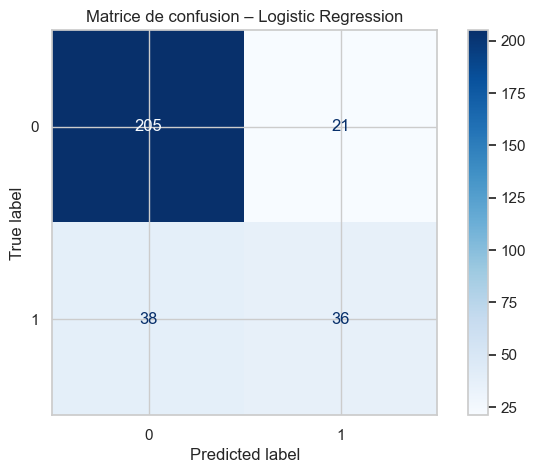

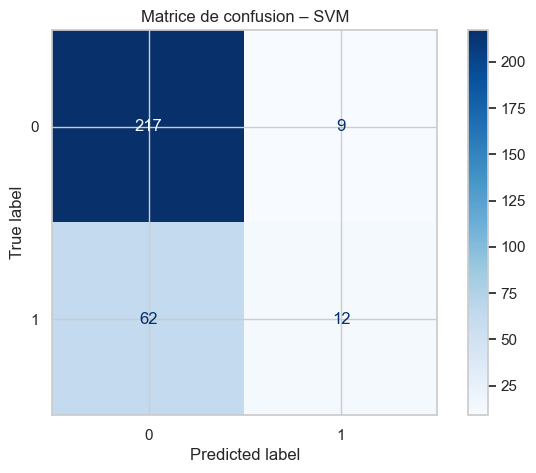

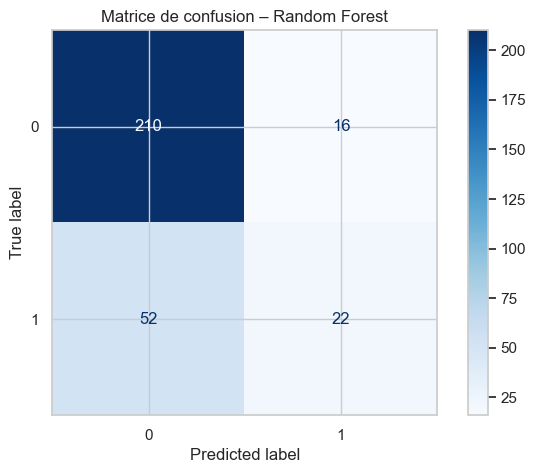

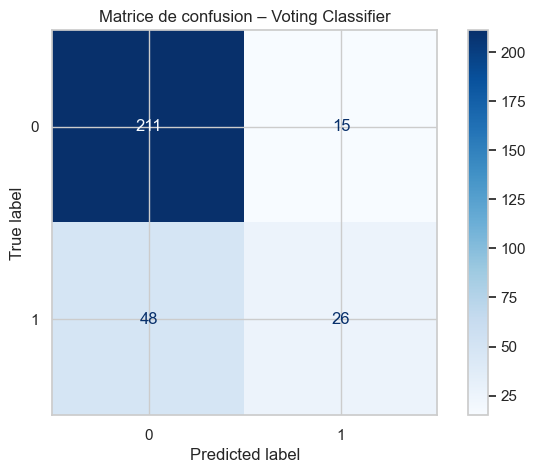

In [11]:
# Cellule 7 – Matrices de confusion pour chaque modèle (Partie B)

from sklearn.metrics import ConfusionMatrixDisplay

for name, model in models.items():
    # Re-fit proprement sur les données d'entraînement rééchantillonnées
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matrice de confusion – {name}")
    plt.show()


Meilleur modèle (F1) : Logistic Regression


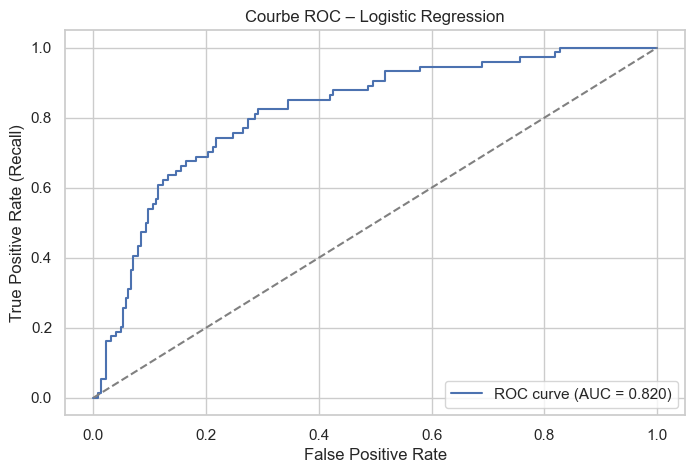


=== Seuil 0.5 ===
Precision : 0.631578947368421
Recall    : 0.4864864864864865
F1-score  : 0.549618320610687

=== Seuil 0.3 ===
Precision : 0.5833333333333334
Recall    : 0.6621621621621622
F1-score  : 0.620253164556962


In [12]:
# Cellule 8 – ROC curve & seuils (Partie C)

# Choix du meilleur modèle selon F1
best_name = results_df.iloc[0]["Model"]
print("Meilleur modèle (F1) :", best_name)

final_model = models[best_name]
final_model.fit(X_train_res, y_train_res)

# Probabilités pour la classe fraude
y_proba = final_model.predict_proba(X_test)[:, 1]

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"Courbe ROC – {best_name}")
plt.legend(loc="lower right")
plt.show()

# Impact du seuil : 0.5 vs 0.3
for thresh in [0.5, 0.3]:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    print(f"\n=== Seuil {thresh} ===")
    print("Precision :", precision_score(y_test, y_pred_thresh))
    print("Recall    :", recall_score(y_test, y_pred_thresh))
    print("F1-score  :", f1_score(y_test, y_pred_thresh))


C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shape shap_vals_class1 : (200, 142)


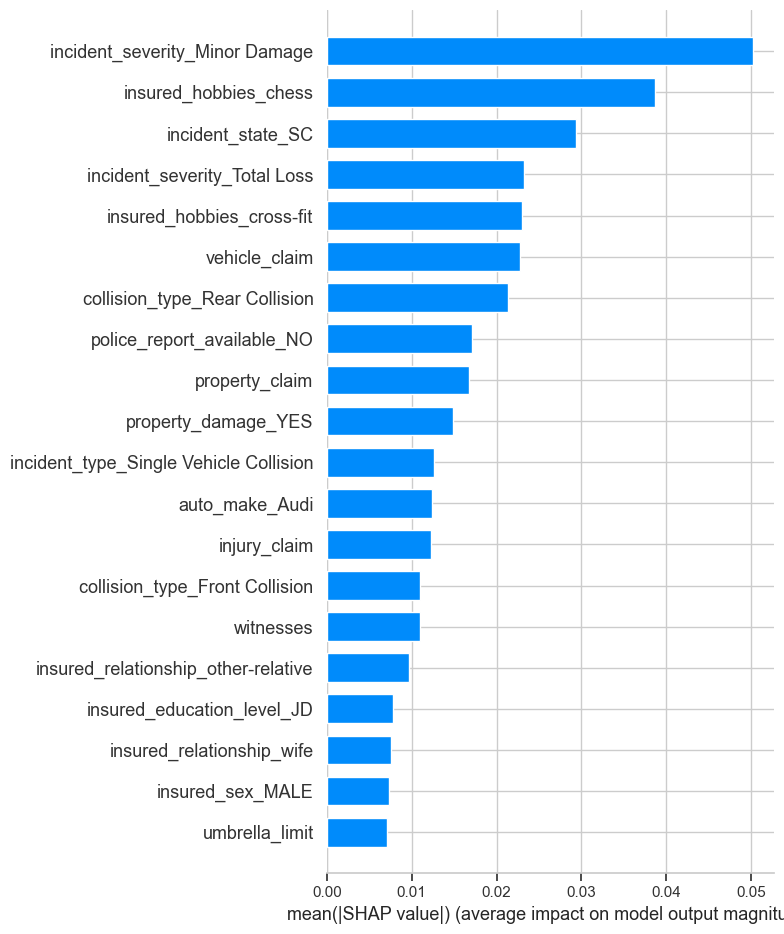

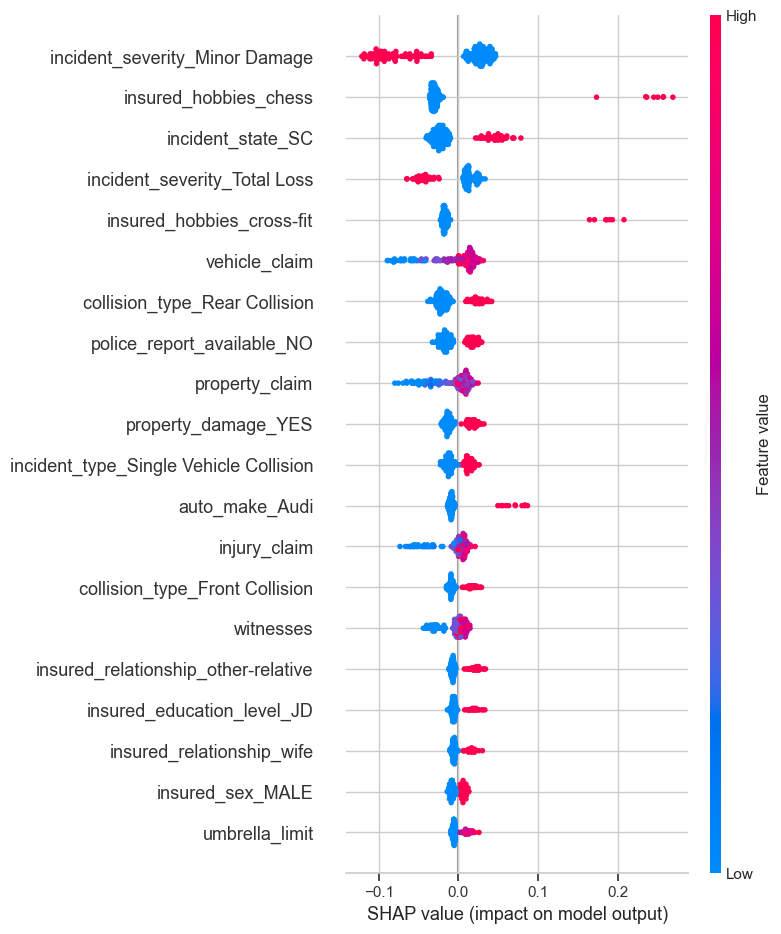

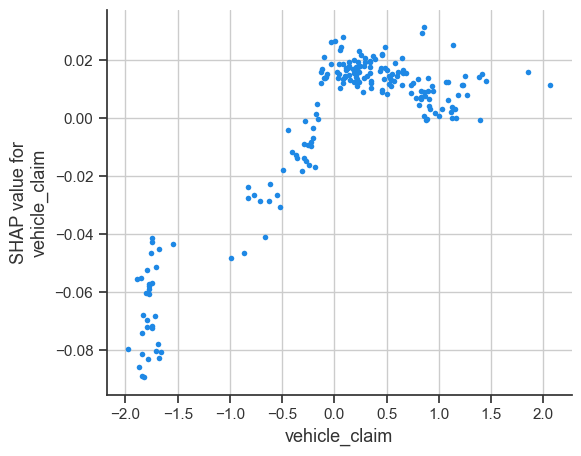

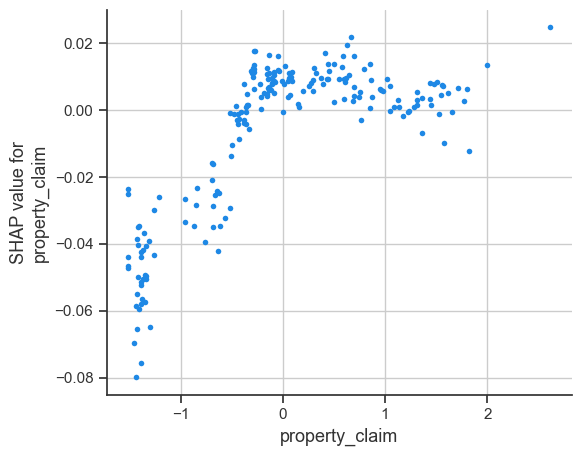

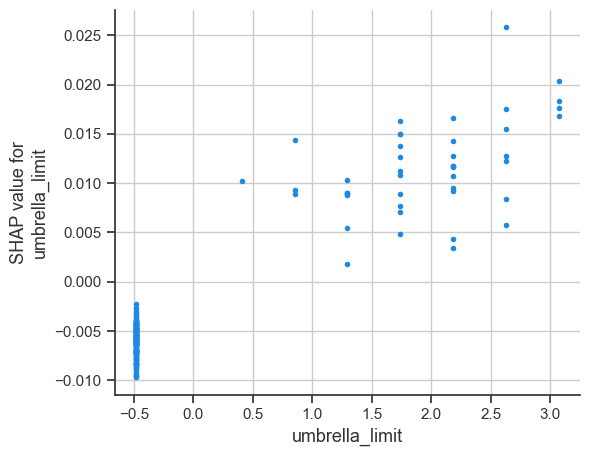

In [13]:
# Cellule 9 – SHAP pour RandomForest (Partie D)

import shap
shap.initjs()

# On travaille avec le Random Forest (même si un autre modèle est le meilleur)
rf_model = models["Random Forest"]
rf_model.fit(X_train_res, y_train_res)

# Échantillon pour SHAP
X_test_sample = X_test.sample(min(200, len(X_test)), random_state=42)

# Explainer
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_sample)

# Problème binaire : on prend la classe 1 (fraude)
if isinstance(shap_values_rf, list):
    shap_vals_class1 = shap_values_rf[1]
else:
    # array (n_samples, n_features, 2)
    shap_vals_class1 = shap_values_rf[:, :, 1]

print("Shape shap_vals_class1 :", shap_vals_class1.shape)

# Summary plot – importance globale
shap.summary_plot(
    shap_vals_class1,
    X_test_sample,
    plot_type="bar",
    show=True
)

# Summary plot – beeswarm (sens des effets)
shap.summary_plot(
    shap_vals_class1,
    X_test_sample,
    show=True
)

# ---- Plots de dépendance pour quelques variables clés ----
features_to_plot = [
    "vehicle_claim",
    "property_claim",
    "umbrella_limit"
]

for feat in features_to_plot:
    if feat in X_test_sample.columns:
        shap.dependence_plot(
            feat,
            shap_vals_class1,
            X_test_sample,
            interaction_index=None,
            show=True
        )


In [14]:
# Cellule 10 – Validation croisée du modèle final (Partie E)

from sklearn.model_selection import StratifiedKFold

# On utilise le modèle final déjà défini : final_model
# Cross-validation sur X_train_res / y_train_res
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(
    final_model,
    X_train_res,
    y_train_res,
    cv=cv,
    scoring='f1'
)

print("Validation croisée (5-fold) sur les données rééchantillonnées")
print("F1-scores :", np.round(f1_scores, 3))
print("F1 moyen :", f1_scores.mean().round(3))
print("Écart-type :", f1_scores.std().round(3))


Validation croisée (5-fold) sur les données rééchantillonnées
F1-scores : [0.9   0.866 0.882 0.891 0.899]
F1 moyen : 0.887
Écart-type : 0.012
